In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU, add, Conv2D, Reshape
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, multiply
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
# K.set_image_data_format('channels_first')

In [2]:
tf.__version__

'2.2.0'

In [3]:
print(tf.keras.backend.image_data_format())

channels_last


In [4]:
tf.keras.backend.set_image_data_format("channels_last")
inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4)
output = lstm(inputs)
print(output.shape)

(32, 4)


In [5]:
class AttentionMaps(tf.keras.layers.Layer):
    """
    Given an image feature map V ∈ R(d×N), and the question representation Q ∈ R(d×T), 
    calculates the affinity matrix C ∈ R(T×N): C = tanh((QT)(Wb)V) ; 
    where Wb ∈ R(d×d) contains the weights. (Refer eqt (3) section 3.3).

    Given this affinity matrix C ∈ R(T×N), predicts image and question attention maps 
    (Refer eqt (4) section 3.3).

    Arguments:
    dim_k     : hidden attention dimention
    reg_value : Regularization value


    Inputs:
    image_feat,    V : shape (N,  d) or (49, dim_d)
    ques_feat,     Q : shape (T,  d) or (23, dim_d)

    Outputs:
    Image and Question attention maps viz:
    a) Hv = tanh(WvV + (WqQ)C) and
    b) Hq = tanh(WqQ + (WvV )CT)
    """
    def __init__(self, dim_k, reg_value, **kwargs):
        super(AttentionMaps, self).__init__(**kwargs)

        self.dim_k = dim_k
        self.reg_value = reg_value

        self.Wv = Dense(self.dim_k, activation=None,\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=2))
        self.Wq = Dense(self.dim_k, activation=None,\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))

    def call(self, image_feat, ques_feat):
        """
        The main logic of this layer.
        """  

        # Affinity Matrix C
        # (QT)(Wb)V 
        C = tf.matmul(ques_feat, tf.transpose(image_feat, perm=[0,2,1])) # [b, 23, 49]
        # tanh((QT)(Wb)V)
        C = tf.keras.activations.tanh(C) 

        # (Wv)V
        WvV = self.Wv(image_feat)                             # [b, 49, dim_k]
        # (Wq)Q
        WqQ = self.Wq(ques_feat)                              # [b, 23, dim_k]

        # ((Wq)Q)C
        WqQ_C = tf.matmul(tf.transpose(WqQ, perm=[0,2,1]), C) # [b, k, 49]
        WqQ_C = tf.transpose(WqQ_C, perm =[0,2,1])            # [b, 49, k]

        # ((Wv)V)CT                                           # [b, k, 23]
        WvV_C = tf.matmul(tf.transpose(WvV, perm=[0,2,1]), tf.transpose(C, perm=[0,2,1]))  

        WvV_C = tf.transpose(WvV_C, perm =[0,2,1])            # [b, 23, k]

        #---------------image attention map------------------
        # We find "Hv = tanh((Wv)V + ((Wq)Q)C)" ; H_v shape [49, k]

        H_v = WvV + WqQ_C                                     # (Wv)V + ((Wq)Q)C
        H_v = tf.keras.activations.tanh(H_v)                  # tanh((Wv)V + ((Wq)Q)C) 

        #---------------question attention map---------------
        # We find "Hq = tanh((Wq)Q + ((Wv)V)CT)" ; H_q shape [23, k]

        H_q = WqQ + WvV_C                                     # (Wq)Q + ((Wv)V)CT
        H_q = tf.keras.activations.tanh(H_q)                  # tanh((Wq)Q + ((Wv)V)CT) 

        return [H_v, H_q]                                     # [b, 49, k], [b, 23, k]

    def get_config(self):
        """
        This method collects the input shape and other information about the layer.
        """
        config = {
            'dim_k': self.dim_k,
            'reg_value': self.reg_value
        }
        base_config = super(AttentionMaps, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
class ContextVector(tf.keras.layers.Layer):
    """
    Method to find context vector of the image and text features
    (Refer eqt (4) and (5) section 3.3).

    Arguments:
    reg_value : Regularization value

    Inputs:
    image_feat V: image features, (49, d)
    ques_feat  Q: question features, (23, d)
    H_v: image attention map, (49, k)
    H_q: question attention map, (23, k)

    Outputs:
    Returns d-dimenstional context vector for image and question features
    """
    def __init__(self, reg_value, **kwargs):
        super(ContextVector, self).__init__(**kwargs)

        self.reg_value = reg_value

        self.w_hv = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
        self.w_hq = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5)) 


    def call(self, image_feat, ques_feat, H_v, H_q):
        """
        The main logic of this layer.
        """  
        # attention probabilities of each image region vn; a_v = softmax(wT_hv * H_v)
        a_v = self.w_hv(H_v)                               # [b, 49, 1]

        # attention probabilities of each word qt ;        a_q = softmax(wT_hq * H_q)
        a_q = self.w_hq(H_q)                               # [b, 23, 1]

        # context vector for image
        v = a_v * image_feat                               # [b, 49, dim_d]
        v = tf.reduce_sum(v, 1)                            # [b, dim_d]

        # context vector for question
        q = a_q * ques_feat                                # [b, 23, dim_d]
        q = tf.reduce_sum(q, 1)                            # [b, dim_d]


        return [v, q]

    def get_config(self):
        """
        This method collects the input shape and other information about the layer.
        """
        config = {
            'reg_value': self.reg_value
        }
        base_config = super(ContextVector, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
class PhraseLevelFeatures(tf.keras.layers.Layer):
    """
    We compute the phrase features by applying 1-D convolution on the word embedding 
    vectors with filters of three window sizes: unigram, bigram and trigram.
    The word-level features Qw are appropriately 0-padded before feeding into bigram and 
    trigram convolutions to maintain the length of the sequence after convolution.
    Given the convolution result, we then apply max-pooling across different n-grams at each word
    location to obtain phrase-level features
    (Refer eqt (1) and (2) section 3.2).

    Arguments:
    dim_d: hidden dimension

    Inputs:
    word_feat Q : word level features of shape (23, dim_d)

    Outputs:
    Phrase level features of the question of shape (23, dim_d)
    """
    def __init__(self, dim_d, **kwargs):
        super(PhraseLevelFeatures, self).__init__(**kwargs)

        self.dim_d = dim_d

        self.conv_unigram = Conv1D(self.dim_d, kernel_size=1, strides=1,\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=6)) 
        self.conv_bigram =  Conv1D(self.dim_d, kernel_size=2, strides=1, padding='same',\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7)) 
        self.conv_trigram = Conv1D(self.dim_d, kernel_size=3, strides=1, padding='same',\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=8)) 


    def call(self, word_feat):
        """
        The main logic of this layer.

        Compute the n-gram phrase embeddings (n=1,2,3)
        """
        # phrase level unigram features
        x_uni = self.conv_unigram(word_feat)                    # [b, 23, dim_d]

        # phrase level bigram features
        x_bi  = self.conv_bigram(word_feat)                     # [b, 23, dim_d]

        # phrase level trigram features
        x_tri = self.conv_trigram(word_feat)                    # [b, 23, dim_d]

        # Concat
        x = tf.concat([tf.expand_dims(x_uni, -1),\
                        tf.expand_dims(x_bi, -1),\
                        tf.expand_dims(x_tri, -1)], -1)         # [b, 23, dim_d, 3]

        # https://stackoverflow.com/a/36853403
        # Max-pool across n-gram features; over-all phrase level feature
        return tf.reduce_max(x, -1)                                # [b, 23, dim_d]

        # return x

    def get_config(self):
        """
        This method collects the input shape and other information about the layer.
        """
        config = {
            'dim_d': self.dim_d
        }
        base_config = super(PhraseLevelFeatures, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
# params 1
max_answers = 1000
max_seq_len = 22
vocab_size  = 25000 + 1
EPOCHS      = 60

dim_d       = 512
dim_k       = 256
l_rate      = 1e-4
d_rate      = 0.5
reg_value   = 0.01

base_path = '/content/drive/My Drive/Capstone/VQA 2/temps'

## Building the Model

In [9]:
image_input = Input(shape=(49, 512, ), name='image_input')
image_feat_dense = Dense(dim_d, activation=None, name='image_feature_dense',\
                            kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1))(image_input)
image_feat = Dropout(d_rate, seed=1)(image_feat_dense)

In [10]:
question_input = Input(shape=(22, ), name='question_input')
ques_feat_w = Embedding(input_dim=vocab_size, output_dim=dim_d,
                        input_length=max_seq_len,\
                        mask_zero=True)(question_input)

In [11]:
Hv_w, Hq_w = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Word')(image_feat, ques_feat_w)
v_w, q_w = ContextVector(reg_value, name='ContextVector_Word')(image_feat, ques_feat_w, Hv_w, Hq_w)
feat_w = tf.add(v_w,q_w)
h_w = Dense(dim_d, activation='tanh', name='h_w_Dense',\
            kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=13))(feat_w)

In [12]:
ques_feat_p = PhraseLevelFeatures(dim_d, name='PhraseLevelFeatures')(ques_feat_w)

In [13]:
Hv_p, Hq_p = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Phrase')(image_feat, ques_feat_p)
v_p, q_p = ContextVector(reg_value, name='ContextVector_Phrase')(image_feat, ques_feat_p, Hv_p, Hq_p)
feat_p = concatenate([tf.add(v_p,q_p), h_w], -1) 
h_p = Dense(dim_d, activation='tanh', name='h_p_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=14))(feat_p)

In [14]:
ques_feat_p, max_seq_len, dim_d

(<tf.Tensor 'PhraseLevelFeatures/Identity:0' shape=(None, 22, 512) dtype=float32>,
 22,
 512)

In [15]:
ques_feat_s = LSTM(dim_d, return_sequences=True,
                   input_shape=(None, max_seq_len, dim_d))(ques_feat_p)

In [16]:
ques_feat_p

<tf.Tensor 'PhraseLevelFeatures/Identity:0' shape=(None, 22, 512) dtype=float32>

In [17]:
Hv_s, Hq_s = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Sent')(image_feat, ques_feat_s)
v_s, q_s = ContextVector(reg_value, name='ContextVector_Sent')(image_feat, ques_feat_p, Hv_s, Hq_s)
feat_s = concatenate([tf.add(v_s,q_s), h_p], -1) 
h_s = Dense(2*dim_d, activation='tanh', name='h_s_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=15))(feat_s)

z   = Dense(2*dim_d, activation='tanh', name='z_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(h_s)
z   = Dropout(d_rate, seed=16)(z)

# result
result = Dense(max_answers, activation='softmax')(z)

model = Model(inputs=[image_input, question_input], outputs=result)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 49, 512)]    0                                            
__________________________________________________________________________________________________
image_feature_dense (Dense)     (None, 49, 512)      262656      image_input[0][0]                
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 49, 512)      0           image_feature_dense[0][0]        
______________________________________________________________________________________________

In [22]:
import pydot, graphviz

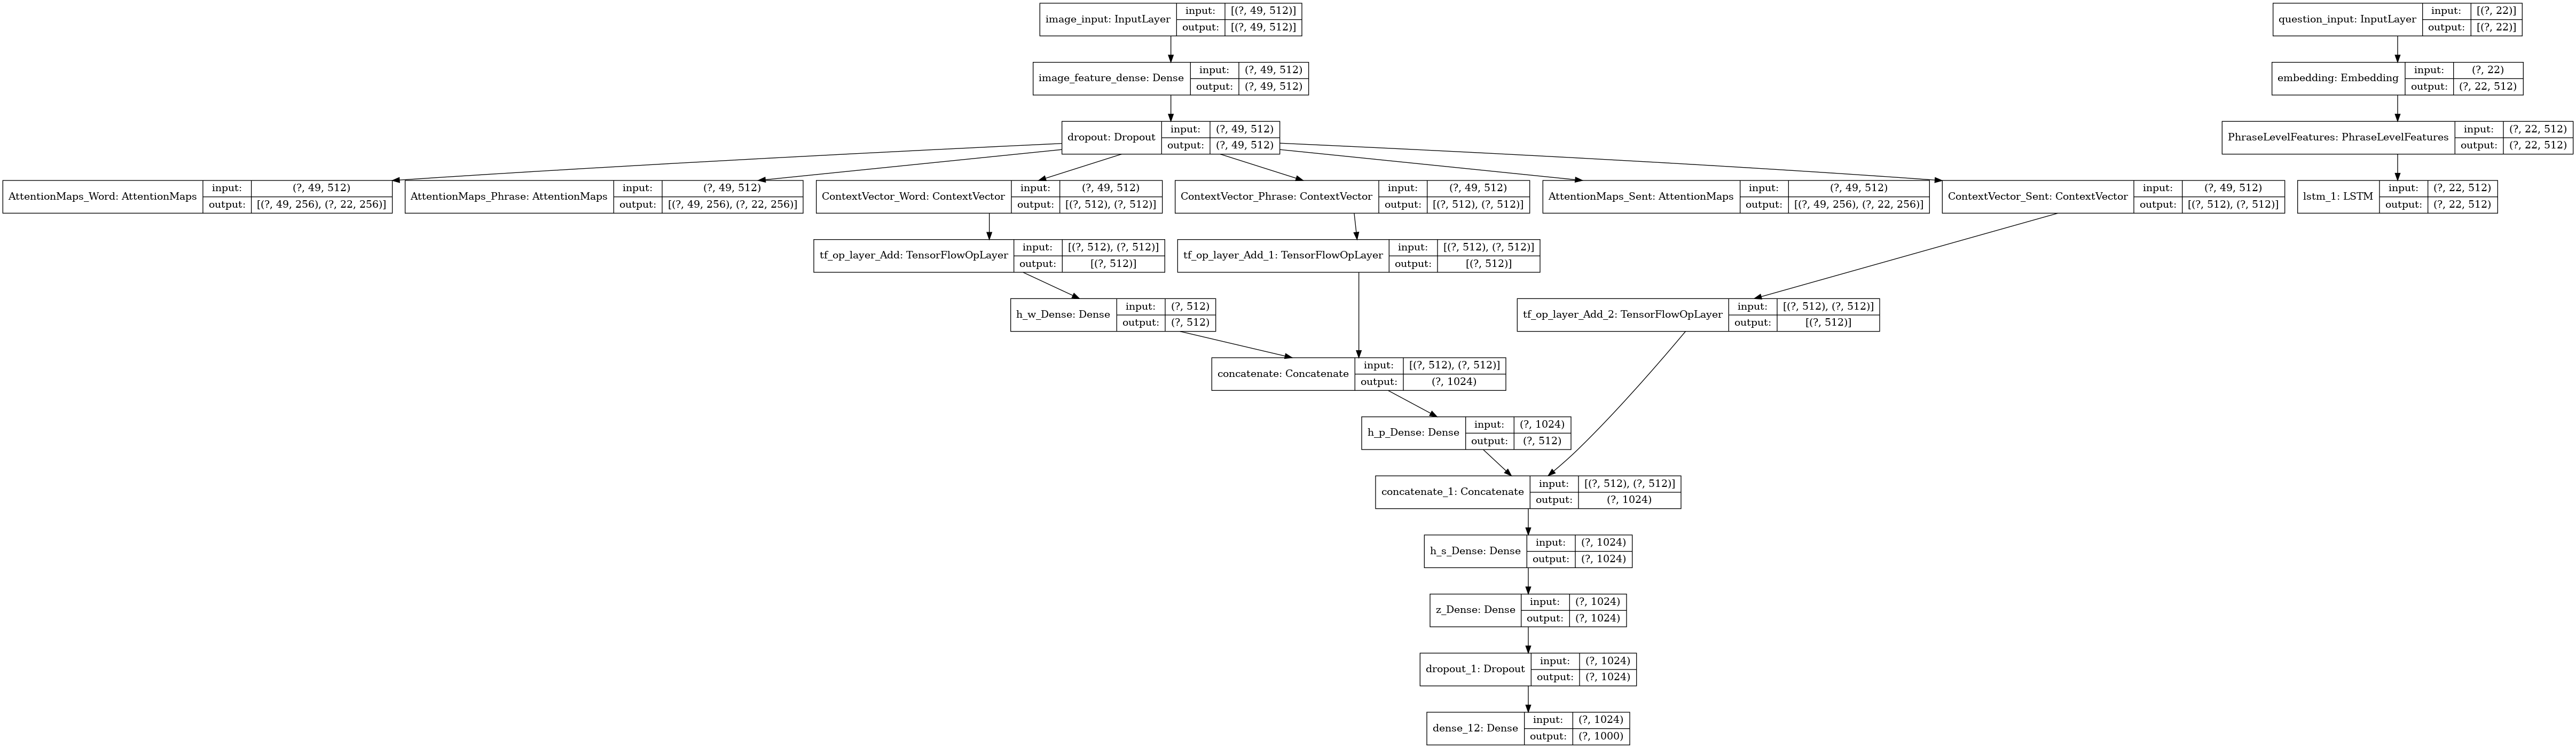

In [23]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)